# Can we find out name of the tree from shape of a leaf?

Dataset from: https://www.kaggle.com/c/leaf-classification/data

#### Description
The dataset consists approximately 1,584 images of leaf specimens (16 samples each of 99 species) which have been converted to binary black leaves against white backgrounds. Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.

# Section 1: Ahem - what do we have in terms of data?

In [39]:
import numpy as np
import pandas as pd

from IPython.display import Image

In [7]:
!ls data

kaggle_images test.csv      train.csv


In [8]:
train_data = pd.read_csv('./data/train.csv')

In [19]:
train_data.shape

(990, 194)

In [28]:
cols = train_data.columns
for col in cols:
    print(col)
    
for i in range(1, 50):
    print(train_data.iloc[0]['shape' + str(i)])

id
species
margin1
margin2
margin3
margin4
margin5
margin6
margin7
margin8
margin9
margin10
margin11
margin12
margin13
margin14
margin15
margin16
margin17
margin18
margin19
margin20
margin21
margin22
margin23
margin24
margin25
margin26
margin27
margin28
margin29
margin30
margin31
margin32
margin33
margin34
margin35
margin36
margin37
margin38
margin39
margin40
margin41
margin42
margin43
margin44
margin45
margin46
margin47
margin48
margin49
margin50
margin51
margin52
margin53
margin54
margin55
margin56
margin57
margin58
margin59
margin60
margin61
margin62
margin63
margin64
shape1
shape2
shape3
shape4
shape5
shape6
shape7
shape8
shape9
shape10
shape11
shape12
shape13
shape14
shape15
shape16
shape17
shape18
shape19
shape20
shape21
shape22
shape23
shape24
shape25
shape26
shape27
shape28
shape29
shape30
shape31
shape32
shape33
shape34
shape35
shape36
shape37
shape38
shape39
shape40
shape41
shape42
shape43
shape44
shape45
shape46
shape47
shape48
shape49
shape50
shape51
shape52
shape53
shape54

In [9]:
train_data.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


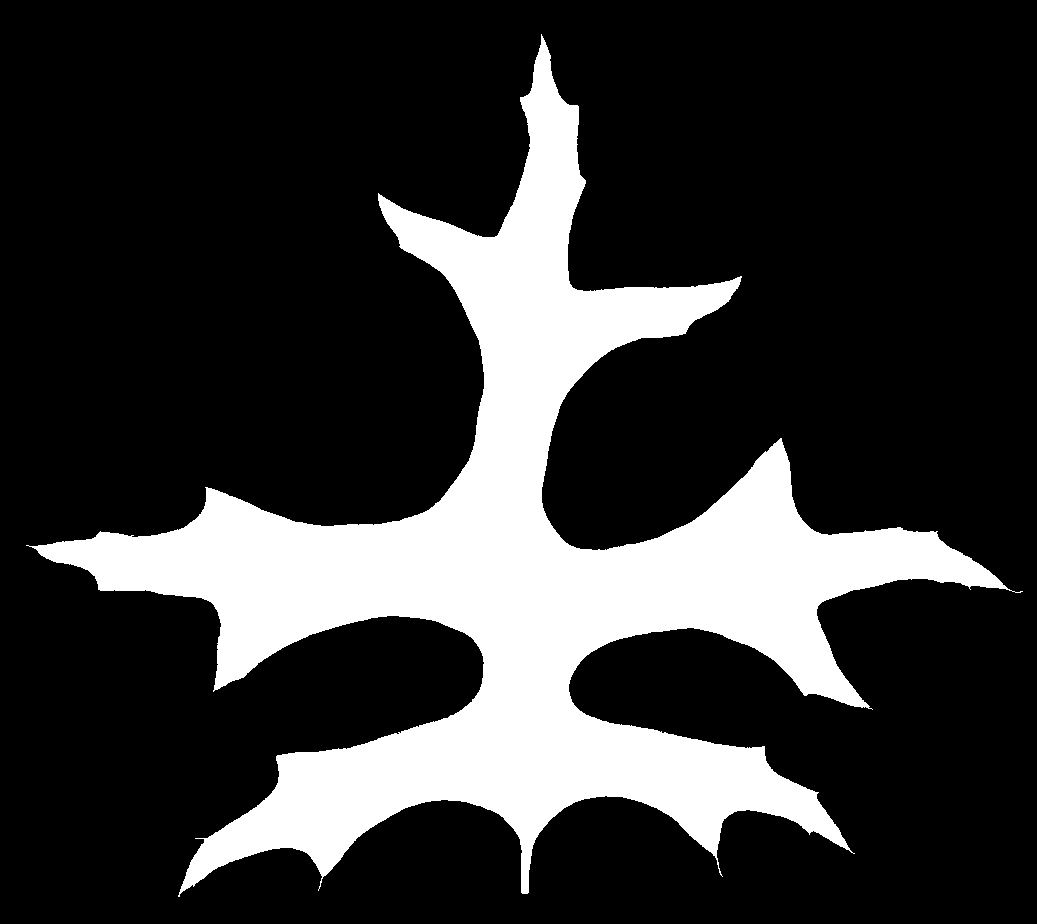

In [103]:
rand_image = './data/kaggle_images/53.jpg'
Image(filename=rand_image, width=400, height=400) 

In [17]:
train_data.__dict__

{'_data': BlockManager
 Items: Index([u'id', u'species', u'margin1', u'margin2', u'margin3', u'margin4',
        u'margin5', u'margin6', u'margin7', u'margin8',
        ...
        u'texture55', u'texture56', u'texture57', u'texture58', u'texture59',
        u'texture60', u'texture61', u'texture62', u'texture63', u'texture64'],
       dtype='object', length=194)
 Axis 1: RangeIndex(start=0, stop=990, step=1)
 FloatBlock: slice(2, 194, 1), 192 x 990, dtype: float64
 IntBlock: slice(0, 1, 1), 1 x 990, dtype: int64
 ObjectBlock: slice(1, 2, 1), 1 x 990, dtype: object,
 '_is_copy': None,
 '_item_cache': {}}

#### Datascience terms:
99 classes, 16 samples from each class.
data per image - id, species, margin (64), shape (64), texture (64)

Now, be mindful that these 3 features are a result of an extensive research and methods themselves.
For example, details about a "shape contiguous descriptor" can be found here:
https://www.math.uci.edu/icamp/summer/research_11/park/shape_descriptors_survey_part3.pdf
and
https://link.springer.com/chapter/10.1007%2F978-3-642-17691-3_32

I have not gone through the links but for the time being, just being respectful to the researchers and taking their word for it. This helps me to keep focus on the main task at hand for now

# Section 2: Additional feature extraction from images
#### Note: This section can be skipped in interest of time

I think I am distracting myself here, but the Kaggle project has this really cool notebook that I want to explore: Step-by-step guide for extracting features from shapes by turning them into time-series. Link: https://www.kaggle.com/lorinc/feature-extraction-from-images

So, here we go.

In [71]:
import matplotlib.image as mpimg       # reading images to numpy arrays
import matplotlib.pyplot as plt        # to plot any graph
import matplotlib.patches as mpatches  # to draw a circle at the mean contour

from skimage import measure            # to find shape contour
from skimage import color
import scipy.ndimage as ndi            # to determine shape centrality

# matplotlib setup
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots

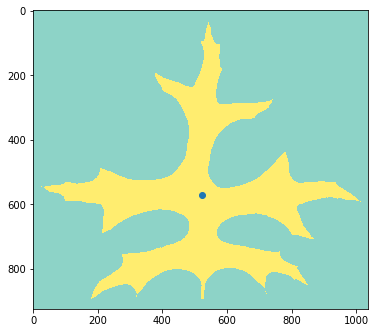

In [61]:
# reading the above image file using matplotlib into a numpy array
img = mpimg.imread('./data/kaggle_images/53.jpg') # img shape is (924, 1037) and consists of values from 0 to 255.
                                                  # but because this is a b/w pic, values are restricted to 0 or 254/255.

# using image processing module of scipy to find the center of the leaf
cy, cx = ndi.center_of_mass(img)

plt.imshow(img, cmap='Set3')  # plot leaf. cmap is for color
plt.scatter(cx, cy)           # plot center
plt.show()

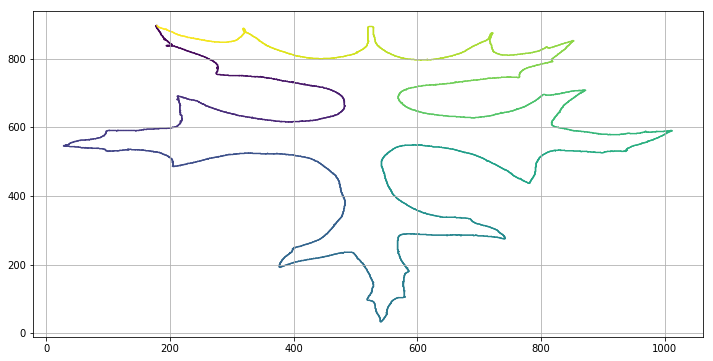

In [117]:
# scikit-learn imaging contour finding, returns a list of found edges
contours = measure.find_contours(img, .8)

# from which we choose the longest one
contour = max(contours, key=len)

# let us see the contour that we hopefully found
# plt.plot(contour[::,1], contour[::,0], linewidth=0.5)  # (I will explain this [::,x] later)
# plt.imshow(img, cmap='Set3')
# plt.show()

plt.scatter(contour[::,1],             
            contour[::,0],             
            linewidth=0, s=2,          
            c=range(len(contour)))
plt.grid()
plt.show()

# Interesting. Let's see how the second parameter in find_contours affects outputs.
# Broadly, find_contours implements a algo where a square of 2x2 is moved across
# the image and the darkest two pixels are picked to be the border. Fair.

# I didn't see any visual difference if I changed it to 0.1.
# Let's change the image and see the difference.

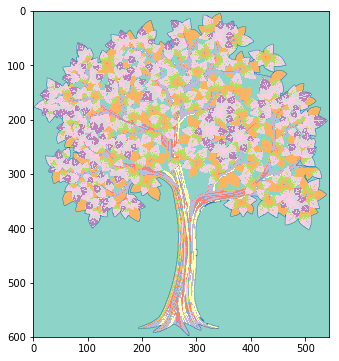

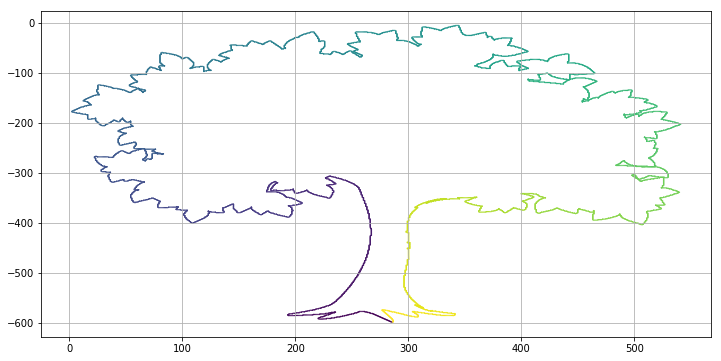

In [124]:
# But first another pretty picture :D

img_random = color.rgb2gray(mpimg.imread('./data/random_images/tree_clipart.png'))

# level = 0.8 does not yield any contour.
# So I think it is related to the size of box being used to move - 
# because it is a more complicated pic, we need a smaller box.

contours_random = measure.find_contours(img_random, level = .1)
contour_random = max(contours_random, key=len)
plt.plot(contour_random[::,1], contour_random[::,0], linewidth=0.5)
plt.imshow(img_random, cmap='Set3')
plt.show()

plt.scatter(contour_random[::,1],             
            -contour_random[::,0],             
            linewidth=0, s=2,          
            c=range(len(contour_random)))
plt.grid()
plt.show()

In [82]:
def cart2pol(x, y):
    # cartesian to polar coordinates
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return [rho, phi]

def get_contour(img, level = 0.8):
    contours = measure.find_contours(img, level)
    contour = max(contours, key=len)
    cy, cx = ndi.center_of_mass(img)
    
    # center the contour to (0, 0) so that polar coords work
    contour[::,1] -= cx  # demean X
    contour[::,0] -= cy  # demean Y

    polar_contour = np.array([cart2pol(x, y) for x, y in contour])
    
    return contour, polar_contour

(600, 544)
(7735, 2)
(7735, 2)


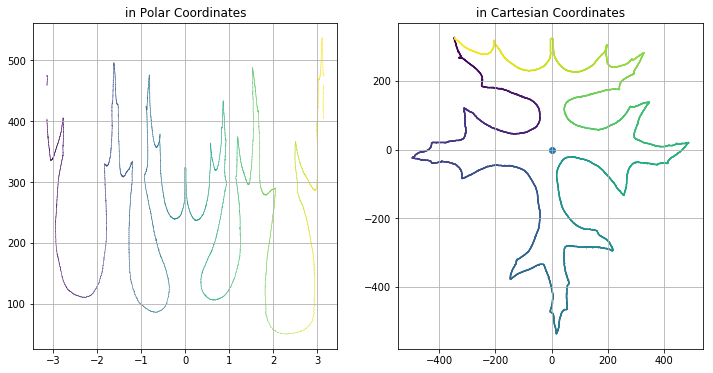

In [98]:
contour, polar_contour = get_contour(img)
print(img_random.shape)
print(contour.shape)
print(polar_contour.shape)

rcParams['figure.figsize'] = (12, 6)

plt.subplot(121)
plt.scatter(polar_contour[::,1],   # x axis is radians
            polar_contour[::,0],   # y axis is distance from center
            linewidth=0, s=.5,     # small points, w/o borders
            c=polar_contour[::,1]) # color dependent on x-axis!
plt.title('in Polar Coordinates')
plt.grid()

plt.subplot(122)
plt.scatter(contour[::,1],             
            contour[::,0],             
            linewidth=0, s=2,          
            c=range(len(contour)))     # continuous coloring (so that plots match)
plt.scatter(0, 0)
plt.title('in Cartesian Coordinates')
plt.grid()

plt.show()

(600, 544)
(5589, 2)
(5589, 2)


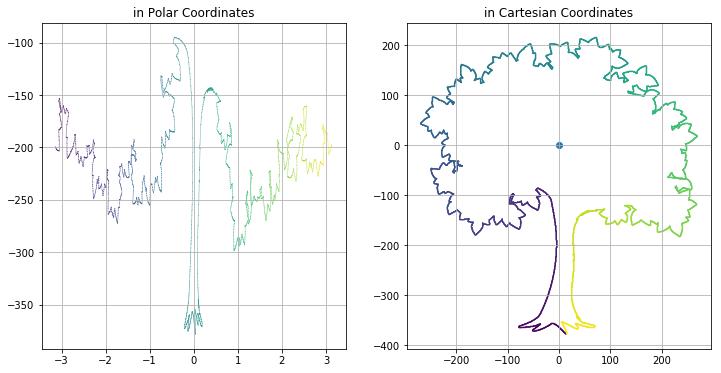

In [100]:
img_random = color.rgb2gray(mpimg.imread('./data/random_images/tree_clipart.png'))
contour, polar_contour = get_contour(img_random, 0.1)
print(img_random.shape)
print(contour.shape)
print(polar_contour.shape)

rcParams['figure.figsize'] = (12, 6)

plt.subplot(121)
plt.scatter(polar_contour[::,1],
            -polar_contour[::,0],     # multiplying by -1 to flip the images.
            linewidth=0, s=.5,
            c=polar_contour[::,1])
plt.title('in Polar Coordinates')
plt.grid()

plt.subplot(122)
plt.scatter(contour[::,1],             
            -contour[::,0],             
            linewidth=0, s=2,          
            c=range(len(contour)))
plt.scatter(0, 0)
plt.title('in Cartesian Coordinates')
plt.grid()

plt.show()

#### Though it looks beautiful, I can see the problem in using this feature - 
#### same x-coord can have multiple y-values. Not impressed by the new feature.

### Abandon!!

# Section 3: Get to real work